<a href="https://colab.research.google.com/github/VMBoehm/MnuLFI/blob/master/LFI_hack_scaled_fullsample_score_compression_Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Score compression of rescaled data (subsamples) with subsequent neural density estimation

In [1]:
!pip install -q https://github.com/VMBoehm/pydelfi/archive/fancy_plots.zip

     | 31.9MB 165.5MB/s
    100% |████████████████████████████████| 235kB 7.0MB/s 


importing packages (new pydelfi API)

In [0]:
import numpy as np
import sys
import pydelfi.priors as priors
import pydelfi.ndes as ndes
import pydelfi.delfi as delfi
import tensorflow as tf
import pydelfi.score as score
tf.logging.set_verbosity(tf.logging.ERROR)
%matplotlib inline
import pickle

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
#drive.mount("/content/gdrive", force_remount=True)

In [0]:

name    = 'BaselineEnsemble'

datapath='./gdrive/My Drive/LFIwithMnus/data/'
restorepath = "./gdrive/My Drive/LFIwithMnus/restore/%s/"%name
plotpath = './gdrive/My Drive/LFIwithMnus/plots/'


In [0]:
import os
if not os.path.isdir(restorepath):
  os.mkdir(restorepath)
  print('path created')
if not os.path.isdir(plotpath):
  os.mkdir(plotpath)
  print('path created')

In [0]:
# fiducial parameters (for compression)
index   = 51
index_0 = 53


### load the data

In [8]:
# load data (note that order of params is not the same as data_sim)
data_scaled        = np.load(datapath+'data_full_set_scaled.npy')
data_scaled_full   = np.load(datapath+'data_scaled_means.npy')
data_scaled_cosmos = np.load(datapath+'params_conc.npy')
data_scaled_cosmos_full = np.load(datapath+'params_conc_means.npy')

covariance = np.load(datapath+'covariance.npy')

theta_fiducial = data_scaled_cosmos_full[index]
print('Fiducial params', theta_fiducial)

Fiducial params [0.1 0.3 2.1]


### Covariance Matrix

In [0]:
# compute covariance from covariance sims
theta_cov = data_scaled_cosmos_full[index_0]
Cov_Inv   = np.linalg.inv(covariance)

### Gaussian process interpolation of (precompressed) data

In [0]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C


kernel = C(1.0, (1e-4, 1e4)) * RBF(1, (1e-4, 1e4))
#Instanciate a Gaussian Process model
gp     = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)


# fit on averages of full rescaled set
gp.fit(data_scaled_cosmos_full,data_scaled_full)

#use the GP prediction to build the model
def fitGP(theta):
    pred, stdev = gp.predict(np.array(theta).reshape(1,3),return_std=True)
    return pred.T

# compute derivative of mean at fiducial model with finite differencing

h      = 0.01

theta1 = np.asarray([theta_fiducial[0]*(1+h), theta_fiducial[1],theta_fiducial[2]])
theta1_= np.asarray([theta_fiducial[0]*(1-h), theta_fiducial[1],theta_fiducial[2]])

theta2 = np.asarray([theta_fiducial[0], theta_fiducial[1]*(1+h),theta_fiducial[2]])
theta2_= np.asarray([theta_fiducial[0], theta_fiducial[1]*(1-h),theta_fiducial[2]])

theta3 = np.asarray([theta_fiducial[0], theta_fiducial[1],theta_fiducial[2]*(1+h)])
theta3_= np.asarray([theta_fiducial[0], theta_fiducial[1],theta_fiducial[2]*(1-h)])

dmudt1 = (fitGP(theta1)-fitGP(theta1_))/(theta1-theta1_)[0]
dmudt2 = (fitGP(theta2)-fitGP(theta2_))/(theta2-theta2_)[1]
dmudt3 = (fitGP(theta3)-fitGP(theta3_))/(theta3-theta3_)[2]

# derivative
dmudt = np.hstack((dmudt1,dmudt2,dmudt3)).T


# set up scrore compression
mu             = fitGP(theta_fiducial)[:,0]
Cinv           = Cov_Inv


Compressor     = score.Gaussian(len(mu), theta_fiducial, mu = mu, Cinv = Cinv, dmudt = dmudt)
Compressor.compute_fisher()
Finv           = Compressor.Finv

def compressor(d, compressor_args):
    return Compressor.scoreMLE(d)
compressor_args=None

In [11]:
try: 
  compressed_train_,data_scaled_c_, compressed_data = pickle.load(open(datapath+'prepared_rescaled_data.pkl','rb'))
  print('loaded compressed data')
except:
  # compress all the (precompressed data) with compressor
  compressed_train = np.zeros((data_scaled.shape[0],data_scaled.shape[1],3))
  data_scaled_c    = np.zeros_like(compressed_train)
  print(compressed_train.shape)

  # loop over cosmologies
  for ii in range(compressed_train.shape[0]):
      for jj in range(compressed_train.shape[1]):
          compressed_train[ii][jj] = compressor(data_scaled[ii][jj],None)
          data_scaled_c[ii][jj] = data_scaled_cosmos_full[ii]
  print(data_scaled_c.shape)

  compressed_train1 = compressed_train[0:index,:,:]

  compressed_train2 = compressed_train[index+1:,:,:]
  print(compressed_train1.shape,compressed_train2.shape)
  compressed_data   = compressed_train[index,:,:]
  compressed_train_ = np.concatenate((compressed_train1,compressed_train2))
  print(compressed_train_.shape, compressed_data.shape)

  data_scaled_c1     = data_scaled_c[0:index,:,:]
  data_scaled_c2     = data_scaled_c[index+1:,:,:]
  data_scaled_c_data = data_scaled_c[index,:,:]
  data_scaled_c_     = np.concatenate((data_scaled_c1,data_scaled_c2))
  print(data_scaled_c_.shape, data_scaled_c_data.shape)
  compressed_train_ = np.reshape(compressed_train_,newshape=(-1,3))
  data_scaled_c_    = np.reshape(data_scaled_c_,newshape=(-1,3))
  print(data_scaled_c_.shape,compressed_train_.shape)
  pickle.dump([compressed_train_,data_scaled_c_, compressed_data],open(datapath+'prepared_rescaled_data.pkl','wb'))

loaded compressed data


### NDE estimation

In [12]:
# set up priors
lower = np.array([np.min(data_scaled_cosmos[:,0]),np.min(data_scaled_cosmos[:,1]),np.min(data_scaled_cosmos[:,2])])
upper = np.array([np.max(data_scaled_cosmos[:,0]),np.max(data_scaled_cosmos[:,1]),np.max(data_scaled_cosmos[:,2])])
print(upper, lower)
prior = priors.Uniform(lower, upper)

[0.62036 0.4159  2.9114 ] [0.     0.1841 1.2886]


In [13]:
# NDEs you wanna train
NDEs = [ndes.ConditionalMaskedAutoregressiveFlow(n_parameters=3, n_data=3, n_hiddens=[50,50], n_mades=5, act_fun=tf.tanh, index=0),
       ndes.MixtureDensityNetwork(n_parameters=3, n_data=3, n_components=1, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=1),
       ndes.MixtureDensityNetwork(n_parameters=3, n_data=3, n_components=2, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=2),
       ndes.MixtureDensityNetwork(n_parameters=3, n_data=3, n_components=3, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=3),
       ndes.MixtureDensityNetwork(n_parameters=3, n_data=3, n_components=4, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=4),
       ndes.MixtureDensityNetwork(n_parameters=3, n_data=3, n_components=5, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=5)]


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [0]:
DelfiEnsemble = delfi.Delfi(compressed_data[0], prior, NDEs, 
                            Finv = Finv, 
                            theta_fiducial = theta_fiducial, 
                            param_limits = [lower, upper],
                            param_names = [r'M_\nu', '\Omega_m', 'A_s'], 
                            results_dir = restorepath,
                            input_normalization="fisher",restore_filename=name+'_restore.pkl', restore=False) 

In [0]:
try:
  posterior_samples = pickle.load(open(restorepath+'posterior_samples_%s.pkl'%name,'rb'))
  DelfiEnsemble.adv_triangle_plot(prior=prior, val_true = data_scaled_c_data[0],val_fid=theta_fiducial,samples=[posterior_samples],plot_fid=True,savefig=True, filename=restorepath+name+'.png')
  print('samples loaded')
except:
  pass

In [0]:
DelfiEnsemble.load_simulations(compressed_train_,data_scaled_c_)

Sampling approximate posterior...
Done.
Removed no burn in


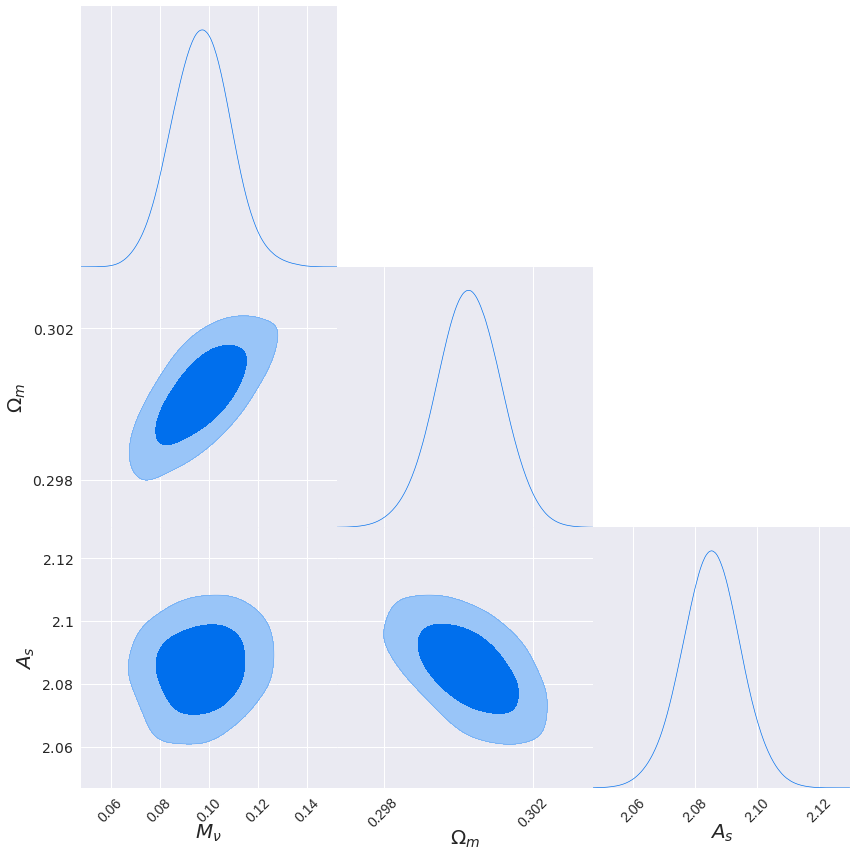

In [17]:
DelfiEnsemble.fisher_pretraining()

In [18]:
DelfiEnsemble.train_ndes()

In [0]:
posterior_samples = DelfiEnsemble.emcee_sample()
pickle.dump(posterior_samples,open('gdrive/My Drive/LFIwithMnus/restore/posterior_samples_%s.pkl'%name,'wb'))

In [0]:
DelfiEnsemble.adv_triangle_plot(prior=prior, val_true = theta_fiducial,val_fid=theta_fiducial,samples=[posterior_samples],plot_fid=True,savefig=True, filename=restorepath+name+'.png')

In [0]:
samples = []
for i in range(4):
    samples.append(DelfiEnsemble.emcee_sample(log_likelihood=lambda x: DelfiEnsemble.log_posterior_individual(i, x)))
for i in range(4):
    DelfiEnsemble.triangle_plot(samples=samples[i:i+1],savefig=True, filename=restorepath+name+'%d'%i+'.png')